In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import skew

In [2]:
df_5 = pd.read_spss('../final_data/caspian-5.sav',convert_categoricals=False)

In [3]:
def rename_features(df1,caspian_number):
    df2 = df1.copy()
    if caspian_number==1:
        df2.rename(columns={'univer': 'university','district':'region', 'schoolty':'schoolType'}, inplace=True)    
    elif caspian_number==3:
        df2.rename(columns={'area':'region', 'heighte':'height','weighte':'weight'}, inplace=True)    
    elif caspian_number==4:
        df2.rename(columns={'weight_1': 'weight', 'height_2': 'height', 'universi': 'university','waist_3':'waist','hip_4':'hip','wrist_5':'wrist'}, inplace=True)        
    elif caspian_number==5:
        df2.rename(columns={'weight_1': 'weight', 'height_2': 'height', 'universi': 'university','ap_9':'schoolType','waist_3':'waist','wrist4':'wrist'}, inplace=True)


    return df2

In [4]:
df_5=rename_features(df_5,5)

In [5]:
df_5.sex.unique()

array([0., 1.])

filter on sex: 1 for boys, 0 for Girl

In [6]:
df_5 = df_5[df_5['sex']==1]

delete some feature based my decision

In [7]:
df_5 = df_5.drop(['var00001', 'univers0', 'region2', 'cluster2', 'cross2', 'sex2', 'birth_y0', 'sample_0'],axis=1)

In [8]:
def preprocess(dataframes_dict):
    processed_dfs = {}  # Dictionary to store processed DataFrames
    for name, df_org in dataframes_dict.items():
        df = df_org.copy()
        df.replace('', np.nan, inplace=True)
        df.replace('?', np.nan, inplace=True)
        # Filter age
        df = df[(df["age"] >= 7) & (df["age"] <= 18)]

        # Convert height and weight to numeric
        df['height'] = pd.to_numeric(df['height'], errors='coerce')
        df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

        # Calculate BMI
        df["bmi1"] = df["weight"] / ((df["height"] / 100) ** 2)

        # Remove null tuples
        records_with_nulls = df[
            df["sex"].isna()
        ]
        df = df.dropna(subset=["sex"])
        missing_percent = df.isna().mean()
        threshold = 0.8
        df = df.loc[:, missing_percent <= threshold]

        # Fill missing values by grouping by age and using the mode
        for col in df.columns:
            if df[col].isna().any():  # Only process columns with missing values
                df[col] = df.groupby('age')[col].transform(
                    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
                )

        print(
            f"Number of records with NaN value in sex in {name}: {len(records_with_nulls)}"
        )

        # Store the processed DataFrame in the new dictionary
        processed_dfs[name] = df

    return processed_dfs

def calculate_percentile_labels(row):
    if row['percentile'] < 5:
        return 'Underweight'
    elif 5 <= row['percentile'] < 85:
        return 'Normal'
    elif 85 <= row['percentile'] < 95:
        return 'Overweight'
    else:
        return 'Obese'

def calculate_percentiles(processed_dfs, feature):
    for name_df, df_org in processed_dfs.items():
        df = df_org.copy()
        
        # Calculate percentiles for each data point
        df['percentile'] = df.groupby(['age', 'sex'])[feature].transform(
            lambda x: 100 * (x.rank(method='average') - 1) / (len(x) - 1)
        )

        # Categorize based on calculated percentiles
        df[f'{feature}_category'] = df.apply(calculate_percentile_labels, axis=1)

        # Update the processed DataFrame
        processed_dfs[name_df] = df

    return processed_dfs

# Add this block to use the script as a module
if __name__ == "__main__":
    # Define your inputs here, or pass them when calling this script
    input_dfs = {  'casp5':df_5
    }

    feature_to_process = 'bmi1'

    processed_dataframes = preprocess(input_dfs)
    final_dfs = calculate_percentiles(processed_dataframes, feature_to_process)

    # Save or output the final results here


/tmp/ipykernel_9834/1104468135.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('', np.nan, inplace=True)


Number of records with NaN value in sex in casp5: 0


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bmi_categories(processed_dfs, feature):
    for name, df in processed_dfs.items():
        # Count the occurrences of each category
        category_counts = df[f'{feature}_category'].value_counts()

        # Plot the counts
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

        # Annotate counts above each bar
        for i, count in enumerate(category_counts.values):
            ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

        # Customize plot
        plt.title(f"Distribution of BMI Categories in {name}")
        plt.xlabel("BMI Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool

import shap

# Define functions
def split_X_y(df_org):
    df = df_org.copy()
    X = df.drop(columns=['weight', 'bmi1', 'id2', 'hip', 'neck', 'wrist', 'waist', 'cluster',
                          'catage', 'cross', 'height','bmi1', 'percentile', 'bmi1_category','hp_101','b_6',
                          'hp_100','hp_101','hp_102','hp_103','hp_104','hp_105'], axis=1)
    y = df['bmi1_category']
    print('X: ',X.shape)
    print('y: ',y.shape)

    return X, y

def select_features(X, y, method, k=50, active=False):
    if active:
        selector = SelectKBest(method, k=k)
        selector.fit(X, y)
        return X.columns[selector.get_support()].tolist()
    else:
        return X.columns.tolist()

def train_catboost(X_train, y_train, iterations=100, random_state=42):
    model = CatBoostClassifier(iterations=iterations, random_seed=random_state, verbose=0)
    model.fit(X_train, y_train)
    return model, iterations

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return {"accuracy": accuracy, "report": report}

def process_and_train_model_for_each_age(final_dfs, catage, k=20):
    for name, df in final_dfs.items():
        results = []
        for cat in catage:
            # Filter dataset for the specific age
            df_age = df[df['catage'] == cat]
            if df_age.empty:
                continue

            X, y = split_X_y(df_age)
            resampling_pipeline = Pipeline([
                ('smote', SMOTE(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42))
            ])

            # Resample the dataset
            X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)

            print(f"Original class distribution:\n{y.value_counts()}")
            print(f"\nResampled class distribution:\n{y_resampled.value_counts()}")
            # smote = SMOTE(random_state=42)
            # X_resampled, y_resampled = smote.fit_resample(X, y)
            # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)
            # X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y,random_state=42)
            X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

            # Feature selection
            selected_features = select_features(X_train, y_train, f_classif, k=k, active=False)
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]
            # print(X_train_selected.shape)
            # Train CatBoost model
            catboost_model, iterations = train_catboost(X_train_selected, y_train)
            catboost_metrics = evaluate_model(catboost_model, X_test_selected, y_test)

            # Calculate feature importance
            feature_importance = catboost_model.get_feature_importance(prettified=False)
            # shap_values = catboost_model.get_feature_importance(
            #     data=Pool(X_train_selected, label=y_train),  # Pass the training data
            #     type='ShapValues'
            # )
            # Exclude the last column (base value)
            # feature_importance = shap_values[:, :-1].mean(axis=0)
            print(f"Feature importance shape: {feature_importance.shape}")
            print(f"X_train_selected columns: {len(X_train_selected.columns)}")
            # Adjust `k` to avoid exceeding available features
            k_adjusted = min(k, len(X_train_selected.columns))
            print(feature_importance)
            # Extract top features
            # top_features = [
            #     X_train_selected.columns[i] 
            #     for i in feature_importance.argsort()[-k_adjusted:][::-1]
            # ]
            # top_features = [X_train_selected.columns[i] for i in feature_importance.argsort()[-k:][::-1]]
            top_features = [X_train_selected.columns[i] for i in feature_importance.argsort()[-k:][::-1]]

            # Append results
            results.append({
                "catage": cat,
                "accuracy": catboost_metrics['accuracy'],
                "num_samples": len(df_age),
                "classification_report": catboost_metrics['report'],
                "top_features": ", ".join(top_features)
            })

        return results


/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
if __name__ == "__main__":
    # Preprocess and calculate percentiles
    input_dfs = {'casp5':df_5}
    processed_dataframes = preprocess(input_dfs)
    final_dfs = calculate_percentiles(processed_dataframes, feature_to_process)
    # Plot BMI category distribution
    plot_bmi_categories(final_dfs, feature_to_process)
    catage = range(1,4)  
    # results = process_and_train_model_for_each_age(final_dfs,catage)
    results = process_and_train_model_for_each_age(final_dfs,catage)
    
    results_df = pd.DataFrame([{
    "catage": r["catage"],
    "accuracy": r["accuracy"],
    "num_samples": r["num_samples"],
    "top_features": r["top_features"],
    "classification_report": r["classification_report"]
} for r in results])

    results_df.to_csv("catage_based_model_results_boys_casp5.csv", index=False)
    print("Results saved to catage_based_model_results.csv.")

NameError: name 'df_5' is not defined

In [12]:
import pandas as pd
import pyreadstat

# Step 1: Extract 'a' series containing features as comma-separated strings
a = results_df['top_features']  # Example pandas Series
type(a)  # Ensure it's a pandas.core.series.Series

# Step 2: Load the .sav file and extract variable labels
df, meta = pyreadstat.read_sav('../final_data/caspian-5.sav')
variable_labels_mapping = dict(zip(meta.column_names, meta.column_labels))

# Step 3: Split features and map each feature to its label
mapped_data = []  # List to store the mapped features and labels

for row in a:
    # Split each row's features by commas, and remove extra whitespace
    features = [feature.strip() for feature in row.split(",")]
    
    # Initialize a row for the current set of features and labels
    row_data = []
    
    # Map each feature to its label and append to the row data
    for feature in features:
        label = variable_labels_mapping.get(feature, "Label not found")
        row_data.append(feature)
        row_data.append(label)
    
    # Append the row to the mapped data
    mapped_data.append(row_data)

# Step 4: Create a DataFrame for the mapped data
# Define the column names for the DataFrame
columns = []
for i in range(len(mapped_data[0]) // 2):  # Assuming two columns per feature-label pair
    columns.extend([f"Feature_{i+1}", f"Label_{i+1}"])

mapped_df = pd.DataFrame(mapped_data, columns=columns)

# Step 5: Transpose the DataFrame so each feature-label pair is a row
transposed_df = mapped_df.transpose()

# Step 6: Save the transposed DataFrame to a CSV file
output_file = "mapped_features_transposed_boys_casp5.csv"
transposed_df.to_csv(output_file, header=False)  # header=False to prevent column names from appearing as rows

print(f"Mapped features and labels saved to: {output_file}")


Mapped features and labels saved to: mapped_features_transposed_boys_casp5.csv


In [13]:
transposed_df

,0,1,2
Feature_1,systolic,region,systolic
Label_1,None,None,None
Feature_2,h_41,systolic,dp_69
Label_2,masrafe panir,None,"taghire dar diet student, kahesh meghdar charbi"
Feature_3,gh_129_3,ap_15,gh_132
Label_3,mizane rezayat va mokhalefat az narahat shodan...,weight pedar dar hemgam ezdevaj,"dar 12 mah gozashte, estefade ruzane az mobile..."
Feature_4,gh_132,gh_132,s_120
Label_4,"dar 12 mah gozashte, estefade ruzane az mobile...","dar 12 mah gozashte, estefade ruzane az mobile...",nahve arzehsyabi shoma dar sale gozashte
Feature_5,region,h_39,bp_32_3
Label_5,None,masrafe shir,"sabegheye hypertention, pedar ya madar bozorg"


In [14]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn

In [15]:
postproc_df = final_dfs['casp5']

In [16]:
postproc_df.columns

Index(['id2', 'University', 'region', 'cluster', 'cross', 'sex', 'birth_ye',
       'sample_c', 'a_1', 'a_2',
       ...
       'parental', 'hp_100', 'hp_101', 'hp_102', 'hp_103', 'hp_104', 'hp_105',
       'bmi1', 'percentile', 'bmi1_category'],
      dtype='object', length=363)

In [17]:
avg_milk_months = postproc_df.groupby(['catage', 'bmi1_category'])['bp_30'].mean().reset_index()

/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


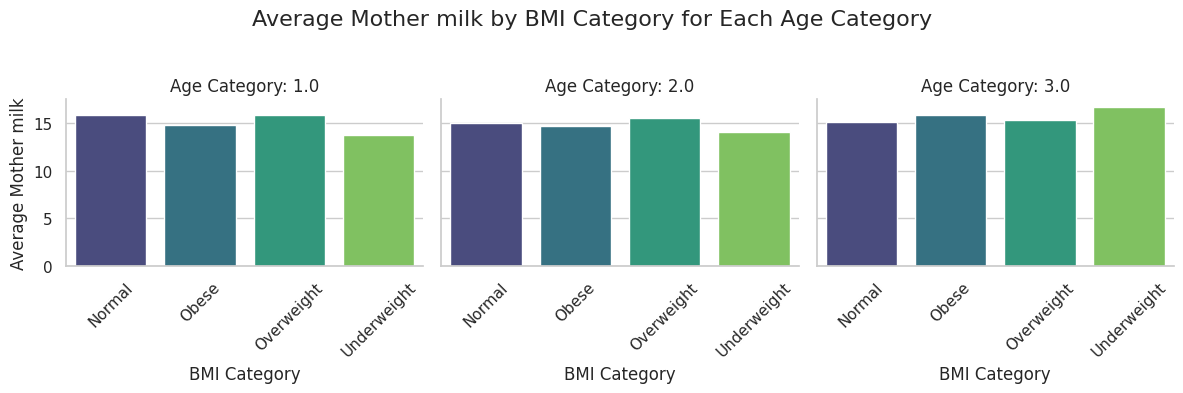

In [18]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a FacetGrid for plotting each `catage` separately
g = sns.FacetGrid(avg_milk_months, col='catage', sharey=True, col_wrap=3, height=4)
g.map(sns.barplot, 'bmi1_category', 'bp_30', order=sorted(avg_milk_months['bmi1_category'].unique()), palette='viridis')

# Customize the plots
g.set_titles("Age Category: {col_name}")
g.set_axis_labels("BMI Category", "Average Mother milk")
g.set_xticklabels(rotation=45)
g.fig.suptitle("Average Mother milk by BMI Category for Each Age Category", fontsize=16)
g.fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for title
plt.show()

In [19]:
postproc_df.gh_132.unique()

array([  0. ,  50. ,  15. ,  35. ,   2. ,  30. ,  10. , 300. , 120. ,
        60. ,   5. ,  40. , 400. , 180. ,  90. , 150. , 240. , 100. ,
        20. ,  12. ,   1. ,   3. ,  11. ,  48. ,   4. , 480. , 140. ,
        70. , 200. , 190. , 360. , 620. , 500. , 600. , 350. ,   9. ,
        75. , 420. ,  45. , 700. , 160. ,   8. , 550. , 220. ,   7. ,
        80. , 370. , 380. , 720. ,  25. ,  24. ,  65. , 250. ,  31.5,
         6. ,  36. ,  26. ,  16. ,  72. , 540. ,  54. ,  43. , 450. ,
       130. ,  18. ])

In [20]:
# ایجاد تابع برای تقسیم‌بندی استفاده از تلفن همراه
def categorize_usage(value):
    if value < 120:
        return 'Low'
    else:
        return 'High'

# اعمال تابع بر روی ستون gh_132
postproc_df['usage_category'] = postproc_df['gh_132'].apply(categorize_usage)

# نمایش نتایج
print(postproc_df[['gh_132', 'usage_category']].head())


    gh_132 usage_category
2      0.0            Low
3      0.0            Low
4     50.0            Low
9     15.0            Low
10    35.0            Low


/tmp/ipykernel_9834/3664633673.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='usage_category', values='percentage', fill_value=0)


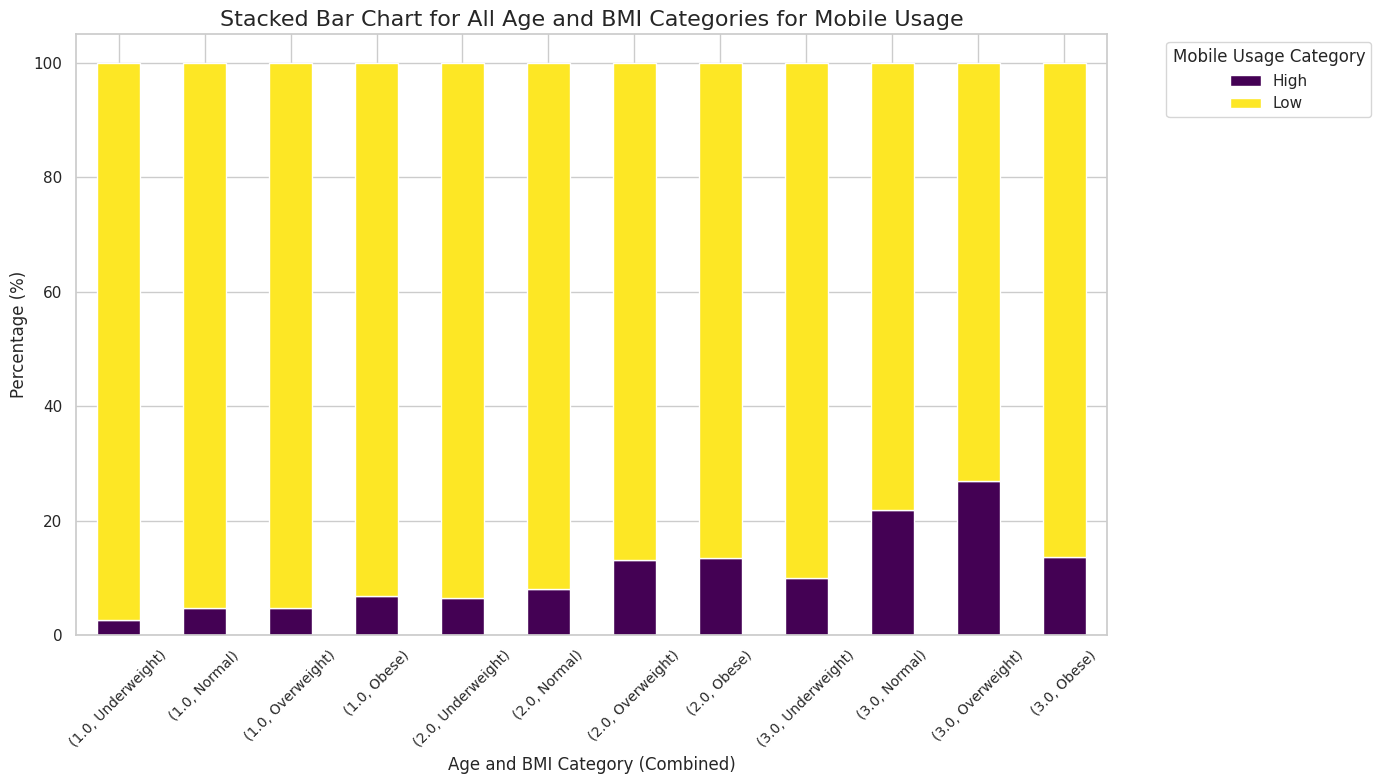

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']
# Group the data and calculate percentages within each (catage, bmi1_category) group
grouped = postproc_df.groupby(['catage', 'bmi1_category', 'usage_category']).size().reset_index(name='count')
grouped['percentage'] = grouped.groupby(['catage', 'bmi1_category'])['count'].transform(lambda x: x / x.sum() * 100)
grouped['bmi1_category'] = pd.Categorical(grouped['bmi1_category'], categories=bmi_order, ordered=True)
# Pivot the data for stacked bar chart
pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='usage_category', values='percentage', fill_value=0)

# Reset the index to plot a single chart
pivot_reset = pivot_df.reset_index()

# Create a stacked bar chart
pivot_reset.set_index(['catage', 'bmi1_category']).plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='viridis',
    ylabel='Percentage (%)'
)

# Customize the chart
plt.title("Stacked Bar Chart for All Age and BMI Categories for Mobile Usage", fontsize=16)
plt.xlabel("Age and BMI Category (Combined)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Mobile Usage Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


تاثیر فشار خون

/tmp/ipykernel_9834/3511885132.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='bp_category', values='percentage', fill_value=0)


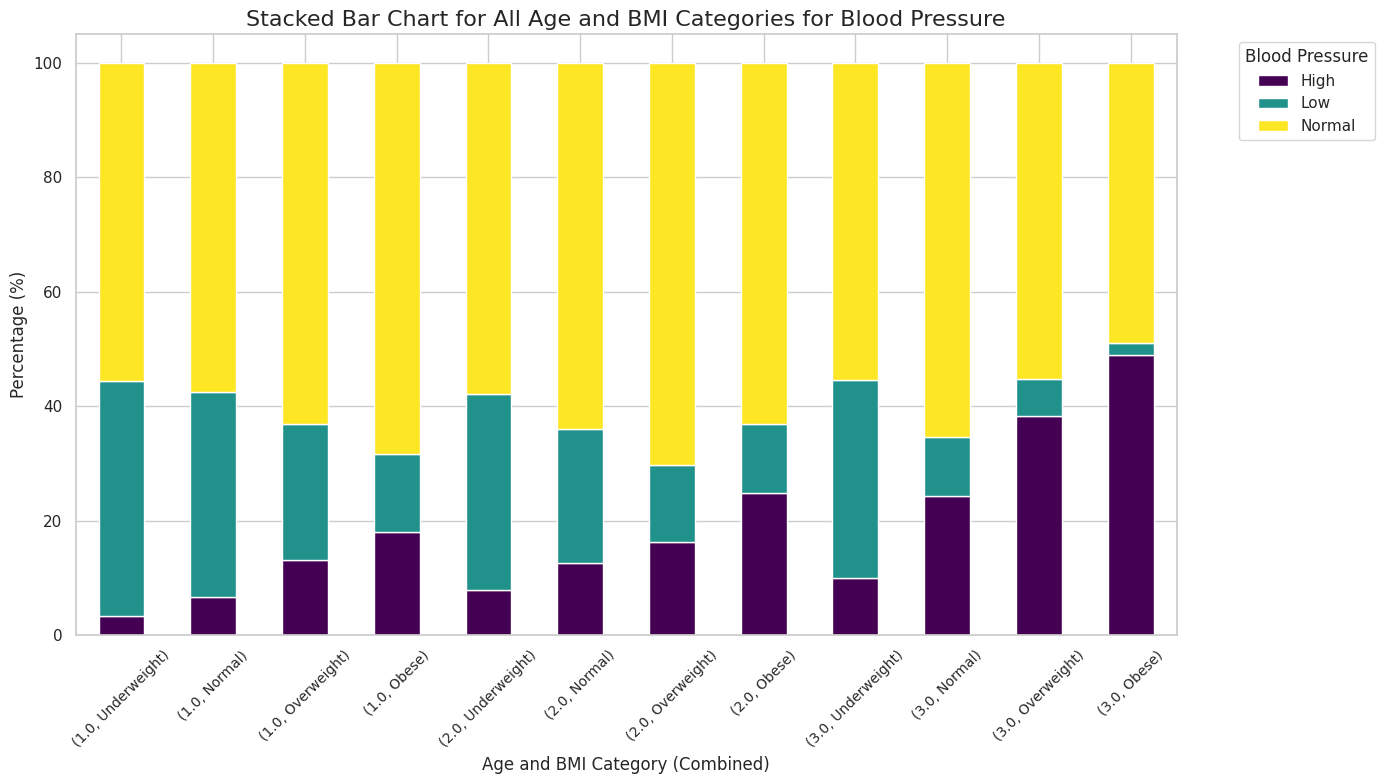

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def categorize_blood_pressure(systolic, diastolic):
    if systolic < 90 or diastolic < 60:
        return 'Low'
    elif systolic < 130 and diastolic < 80:
        return 'Normal'
    else:
        return 'High'
bp_category = [categorize_blood_pressure(s, d) for s, d in zip(postproc_df['systolic'], postproc_df['diastoli'])]
postproc_df['bp_category'] = bp_category
# Define the custom order for bmi1_category (adjust according to your actual categories)
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']

# Group the data and calculate percentages within each (catage, bmi1_category) group
grouped = postproc_df.groupby(['catage', 'bmi1_category', 'bp_category']).size().reset_index(name='count')
grouped['percentage'] = grouped.groupby(['catage', 'bmi1_category'])['count'].transform(lambda x: x / x.sum() * 100)

# Ensure bmi1_category is in the correct order
grouped['bmi1_category'] = pd.Categorical(grouped['bmi1_category'], categories=bmi_order, ordered=True)

# Pivot the data for stacked bar chart
pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='bp_category', values='percentage', fill_value=0)

# Reset the index to plot a single chart
pivot_reset = pivot_df.reset_index()

# Create a stacked bar chart
pivot_reset.set_index(['catage', 'bmi1_category']).plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='viridis',
    ylabel='Percentage (%)'
)

# Customize the chart
plt.title("Stacked Bar Chart for All Age and BMI Categories for Blood Pressure", fontsize=16)
plt.xlabel("Age and BMI Category (Combined)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Blood Pressure", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


ساعات خوردن شام در طول هفته

In [23]:
def categorize_dinner_hour(hour):
    if hour >= 17 and hour < 19:
        return 'Early'
    elif hour >= 19 and hour < 21:
        return 'Mid'
    else:
        return 'Late'

# اعمال تابع به ستون 'h_27' برای دسته‌بندی
postproc_df['dinner_time_category'] = postproc_df['h_27'].apply(categorize_dinner_hour)


/tmp/ipykernel_9834/3407964760.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='dinner_time_category', values='percentage', fill_value=0)


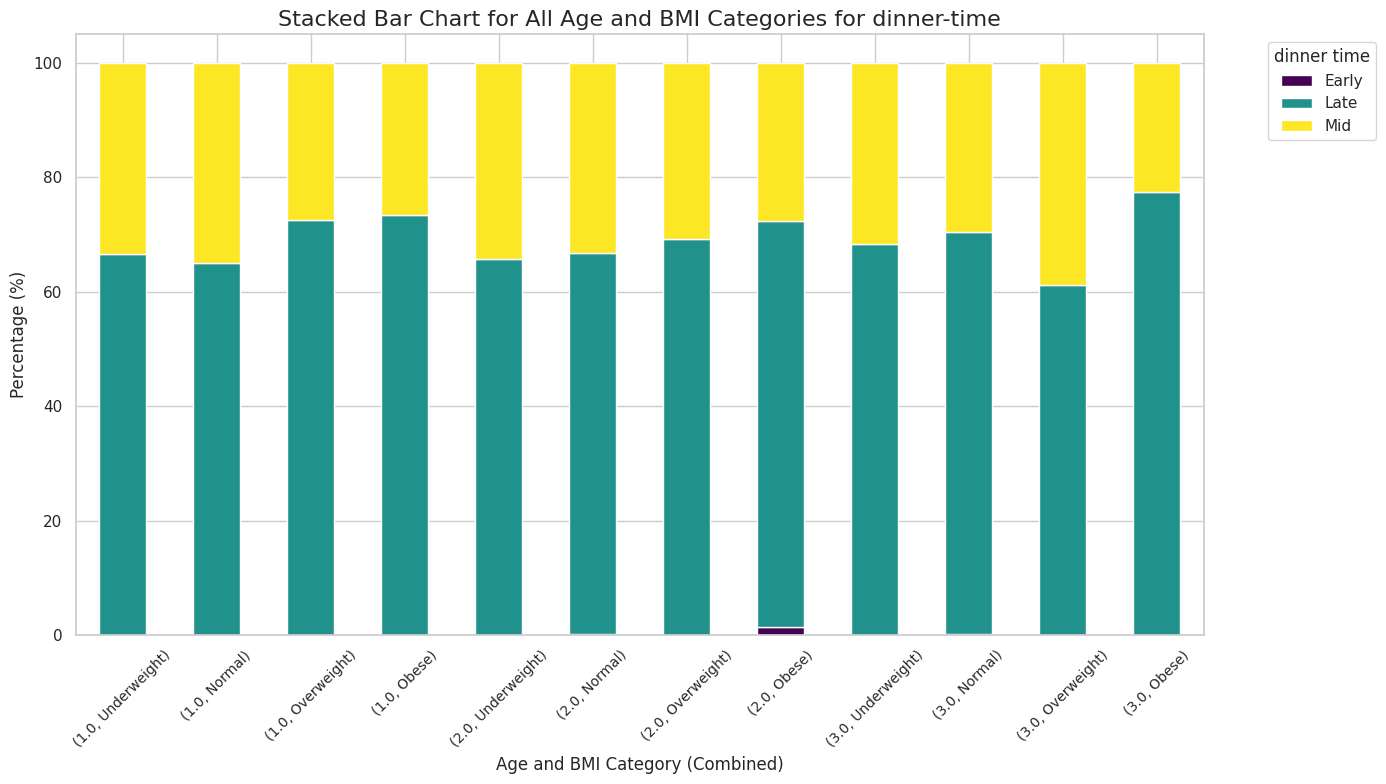

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']

# Group the data and calculate percentages within each (catage, bmi1_category) group
grouped = postproc_df.groupby(['catage', 'bmi1_category', 'dinner_time_category']).size().reset_index(name='count')
grouped['percentage'] = grouped.groupby(['catage', 'bmi1_category'])['count'].transform(lambda x: x / x.sum() * 100)

# Ensure bmi1_category is in the correct order
grouped['bmi1_category'] = pd.Categorical(grouped['bmi1_category'], categories=bmi_order, ordered=True)

# Pivot the data for stacked bar chart
pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='dinner_time_category', values='percentage', fill_value=0)

# Reset the index to plot a single chart
pivot_reset = pivot_df.reset_index()

# Create a stacked bar chart
pivot_reset.set_index(['catage', 'bmi1_category']).plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='viridis',
    ylabel='Percentage (%)'
)

# Customize the chart
plt.title("Stacked Bar Chart for All Age and BMI Categories for dinner-time", fontsize=16)
plt.xlabel("Age and BMI Category (Combined)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="dinner time", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


چند ساعت در هفته در فصل تابستان در پارک وقت گذرانده اید

In [25]:
def categorize_park_hours(hours):
    if hours < 10:
        return 'Less than 10 hours'
    elif 10 <= hours <= 20:
        return '10-20 hours'
    else:
        return 'More than 20 hours'
    
postproc_df['summer_park_time'] = postproc_df['v127_2_1'].apply(categorize_park_hours)

/tmp/ipykernel_9834/543263377.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='summer_park_time', values='percentage', fill_value=0)


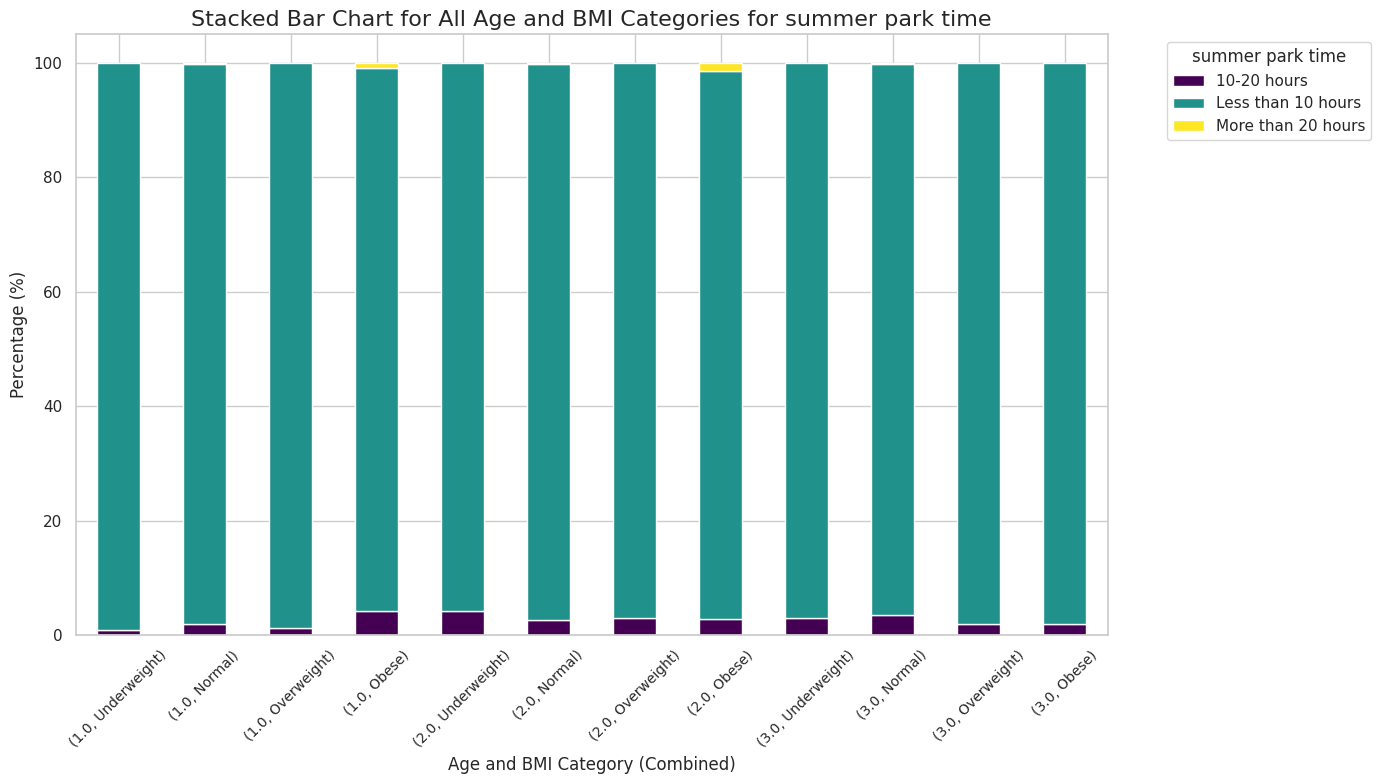

In [26]:
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']

# Group the data and calculate percentages within each (catage, bmi1_category) group
grouped = postproc_df.groupby(['catage', 'bmi1_category', 'summer_park_time']).size().reset_index(name='count')
grouped['percentage'] = grouped.groupby(['catage', 'bmi1_category'])['count'].transform(lambda x: x / x.sum() * 100)

# Ensure bmi1_category is in the correct order
grouped['bmi1_category'] = pd.Categorical(grouped['bmi1_category'], categories=bmi_order, ordered=True)

# Pivot the data for stacked bar chart
pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='summer_park_time', values='percentage', fill_value=0)

# Reset the index to plot a single chart
pivot_reset = pivot_df.reset_index()

# Create a stacked bar chart
pivot_reset.set_index(['catage', 'bmi1_category']).plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='viridis',
    ylabel='Percentage (%)'
)

# Customize the chart
plt.title("Stacked Bar Chart for All Age and BMI Categories for summer park time", fontsize=16)
plt.xlabel("Age and BMI Category (Combined)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="summer park time", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

میزان فعالیت بدنی که منجر به عرق کردن یا خسته شدن بشود در هفته

In [27]:
postproc_df['exercise_hour_week'] = df[['z_56_1', 'z_56_2','z_56_3', 'z_56_4', 'z_56_5', 'z_56_6', 'z_56_7']].sum(axis=1)

In [28]:
postproc_df['exercise_hour_week'].unique()

array([32.,  8., 21., 16., 24., 27., 23., 15., 10.,  0., 14.,  7., 28.,
       11., 18., 35., 12., 19., 20., 13., 17., 30., 22., 26.,  9., 31.,
       33., 25.,  2.,  6., 29.,  4., 34.,  5.,  3.])

In [29]:
categories = pd.cut(postproc_df['exercise_hour_week'], bins=3, labels=['Low', 'Medium', 'High'])
postproc_df['exercise_category'] = categories
# Display the categorized results
print(categories)

2          High
3           Low
4        Medium
9        Medium
10         High
          ...  
13977      High
13978    Medium
13979      High
13980    Medium
13982    Medium
Name: exercise_hour_week, Length: 7085, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']


/tmp/ipykernel_9834/779886454.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = postproc_df.groupby(['catage', 'bmi1_category', 'exercise_category']).size().reset_index(name='count')
/tmp/ipykernel_9834/779886454.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='exercise_category', values='percentage', fill_value=0)


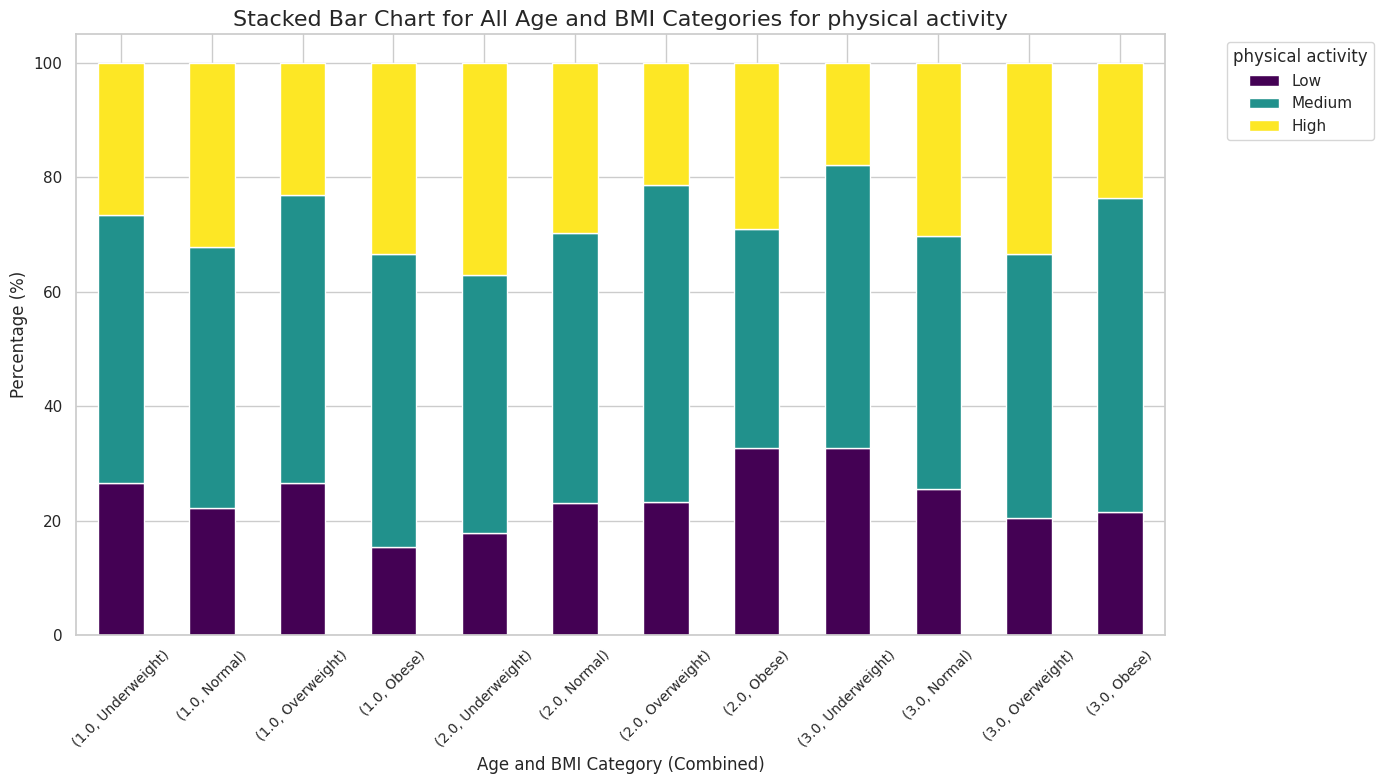

In [30]:
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']

# Group the data and calculate percentages within each (catage, bmi1_category) group
grouped = postproc_df.groupby(['catage', 'bmi1_category', 'exercise_category']).size().reset_index(name='count')
grouped['percentage'] = grouped.groupby(['catage', 'bmi1_category'])['count'].transform(lambda x: x / x.sum() * 100)

# Ensure bmi1_category is in the correct order
grouped['bmi1_category'] = pd.Categorical(grouped['bmi1_category'], categories=bmi_order, ordered=True)

# Pivot the data for stacked bar chart
pivot_df = grouped.pivot_table(index=['catage', 'bmi1_category'], columns='exercise_category', values='percentage', fill_value=0)

# Reset the index to plot a single chart
pivot_reset = pivot_df.reset_index()

# Create a stacked bar chart
pivot_reset.set_index(['catage', 'bmi1_category']).plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='viridis',
    ylabel='Percentage (%)'
)

# Customize the chart
plt.title("Stacked Bar Chart for All Age and BMI Categories for physical activity", fontsize=16)
plt.xlabel("Age and BMI Category (Combined)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="physical activity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Clustering

In [31]:
cluster_df = final_dfs['casp5'] 
cluster_df= cluster_df.drop(columns=['weight', 'bmi1', 'id2', 'hip', 'neck', 'wrist', 'waist', 'cluster',
                          'cross', 'height','bmi1', 'percentile', 'bmi1_category','hp_101','b_6',
                          'hp_100','hp_101','hp_102','hp_103','hp_104','hp_105'], axis=1)
cluster_df = cluster_df.groupby(['catage'])

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd

a = results_df['top_features']
# Initialize a list to store results
cluster_results = []

# Iterate over each group in the grouped DataFrame
for i, (group_name, group_data) in enumerate(cluster_df):
    row = a.iloc[i]  # Use .iloc to access the string in the Series
    # Split each row's features by commas, and remove extra whitespace
    features = [feature.strip() for feature in row.split(",")]

    
    # Filter the group's DataFrame for the selected features
    selected_features = features
    # print(selected_features)
    filtered_group_df = group_data[selected_features]
    # print(filtered_group_df.shape)
    # Normalize the data using StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(filtered_group_df)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
    labels = dbscan.fit_predict(scaled_data)

    # Add cluster labels to the group's DataFrame
    filtered_group_result = filtered_group_df.copy()
    filtered_group_result['Cluster'] = labels
    print(filtered_group_result.shape)
    # Store the result
    cluster_results.append((group_name, filtered_group_result))
# Combine all results into a single DataFrame if needed
# final_result = pd.concat([result[1] for result in cluster_results], ignore_index=True)


(2303, 21)
(2773, 21)
(2009, 21)


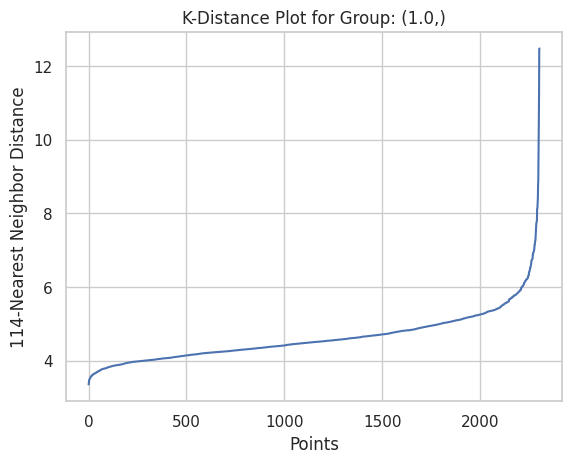

Group: (1.0,) | Estimated eps: 6.529 | min_samples: 115
Metrics for Group: (1.0,)
  Clustering metrics not applicable (less than 2 clusters)


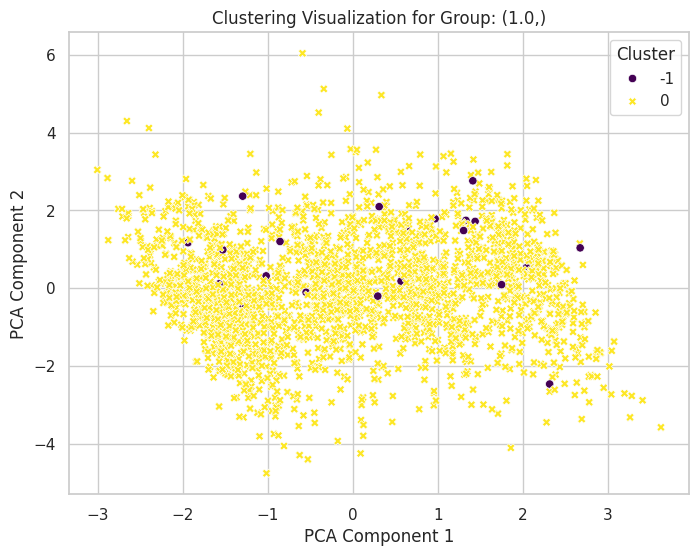

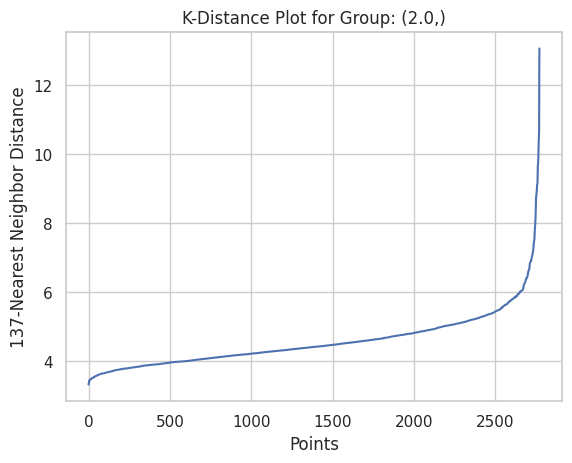

Group: (2.0,) | Estimated eps: 6.386 | min_samples: 138
Metrics for Group: (2.0,)
  Clustering metrics not applicable (less than 2 clusters)


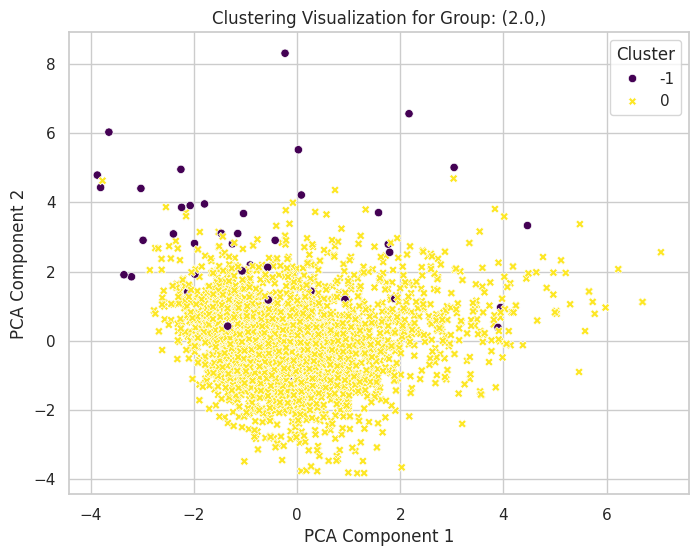

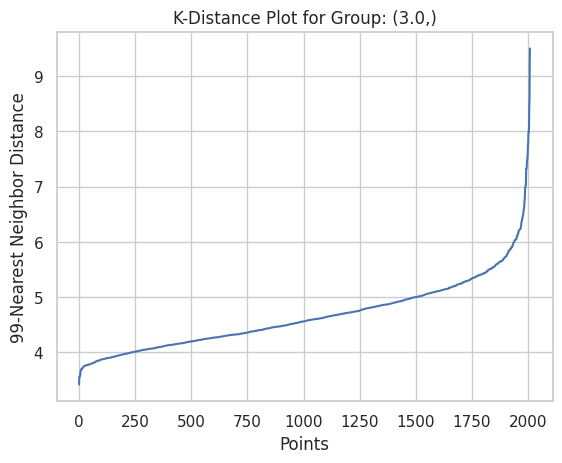

Group: (3.0,) | Estimated eps: 7.325 | min_samples: 100
Metrics for Group: (3.0,)
  Clustering metrics not applicable (less than 2 clusters)


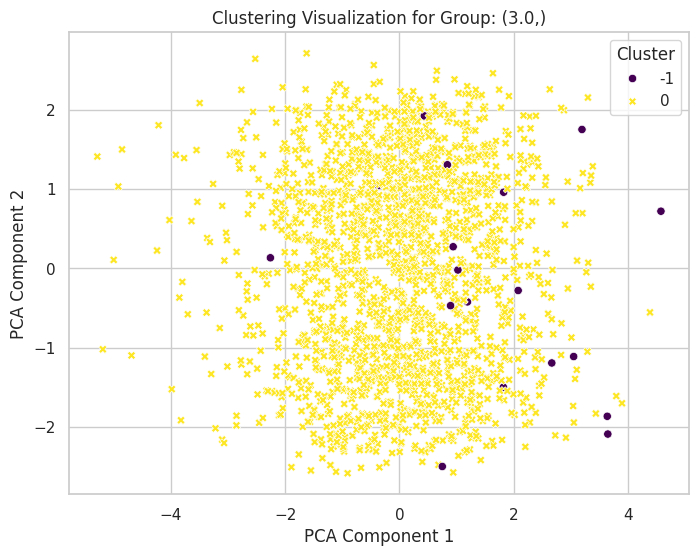

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

a = results_df['top_features']

for i, (group_name, group_data) in enumerate(cluster_df):
    row = a.iloc[i]
    features = [feature.strip() for feature in row.split(",")]
    filtered_group_df = group_data[features]

    # Normalize the data using StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(filtered_group_df)

    # Dynamically determine min_samples
    min_samples = max(2, int(0.05 * len(filtered_group_df)))  # 5% of the dataset size, minimum of 2

    # Dynamically determine eps using k-distance plot
    k = min_samples - 1  # Choose k = min_samples - 1
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(scaled_data)
    distances, indices = neighbors_fit.kneighbors(scaled_data)

    # Sort distances to find the elbow point
    distances = np.sort(distances[:, -1])
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel(f"{k}-Nearest Neighbor Distance")
    plt.title(f"K-Distance Plot for Group: {group_name}")
    plt.show()

    # Find the elbow point as the optimal eps
    knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    eps = distances[knee_locator.knee] if knee_locator.knee else distances[int(0.9 * len(distances))]  # Fallback if no knee is found

    print(f"Group: {group_name} | Estimated eps: {eps:.3f} | min_samples: {min_samples}")

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5, min_samples=25)
    labels = dbscan.fit_predict(scaled_data)

    # Add cluster labels to the group's DataFrame
    filtered_group_result = filtered_group_df.copy()
    filtered_group_result['Cluster'] = labels

    # Calculate clustering metrics
    if len(set(labels)) > 1 and -1 not in labels:  # At least two clusters (excluding noise)
        silhouette = silhouette_score(scaled_data, labels)
        davies_bouldin = davies_bouldin_score(scaled_data, labels)
        calinski_harabasz = calinski_harabasz_score(scaled_data, labels)

        print(f"Metrics for Group: {group_name}")
        print(f"  Silhouette Score: {silhouette:.3f}")
        print(f"  Davies-Bouldin Index: {davies_bouldin:.3f}")
        print(f"  Calinski-Harabasz Index: {calinski_harabasz:.3f}")
    else:
        print(f"Metrics for Group: {group_name}")
        print("  Clustering metrics not applicable (less than 2 clusters)")

    # Visualization
    # Reduce dimensionality for visualization using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        hue=labels,
        palette="viridis",
        style=labels,
        legend="full"
    )
    plt.title(f"Clustering Visualization for Group: {group_name}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.show()


In [35]:
import sys
!{sys.executable} -m pip install kneed

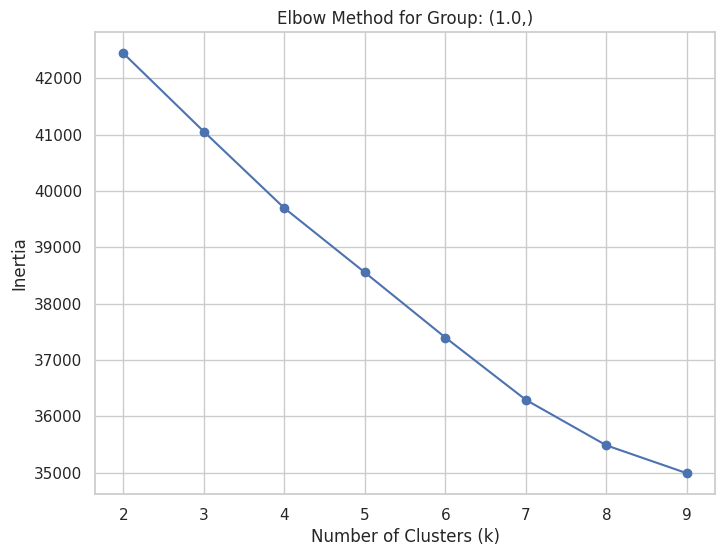

Metrics for Group: (1.0,)
  Silhouette Score: 0.056
  Davies-Bouldin Index: 2.855
  Calinski-Harabasz Index: 97.726


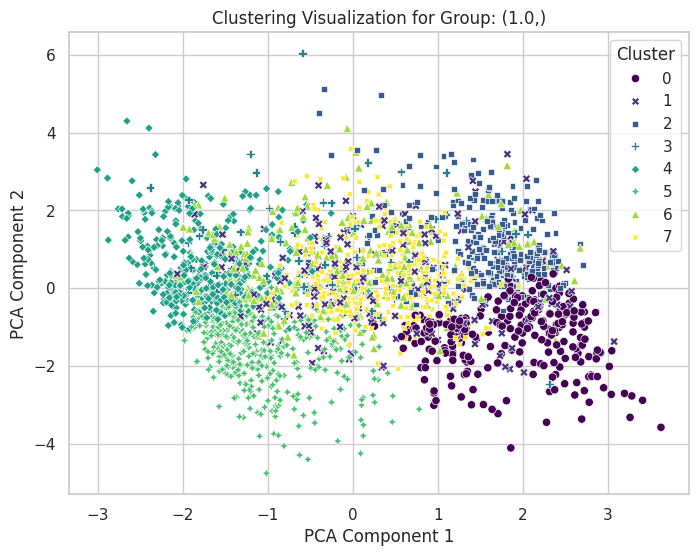

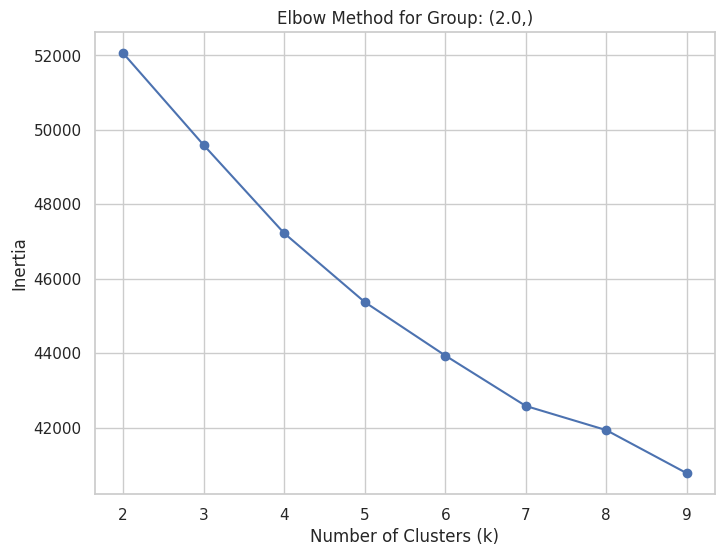

Metrics for Group: (2.0,)
  Silhouette Score: 0.060
  Davies-Bouldin Index: 2.555
  Calinski-Harabasz Index: 127.432


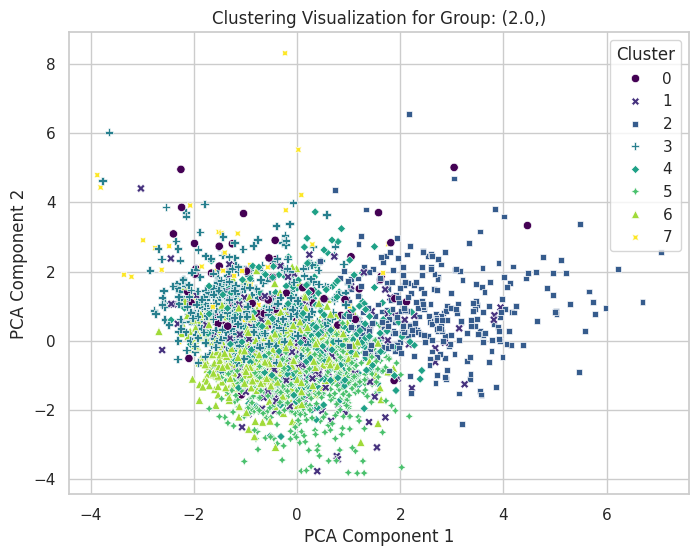

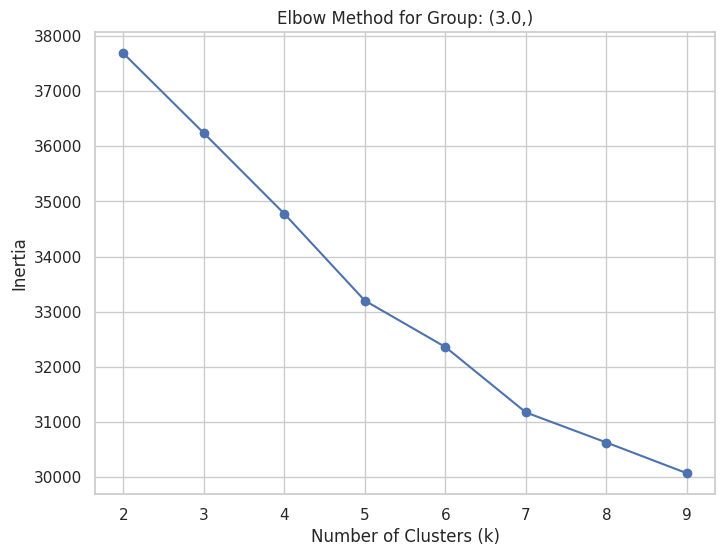

Metrics for Group: (3.0,)
  Silhouette Score: 0.052
  Davies-Bouldin Index: 2.836
  Calinski-Harabasz Index: 89.102


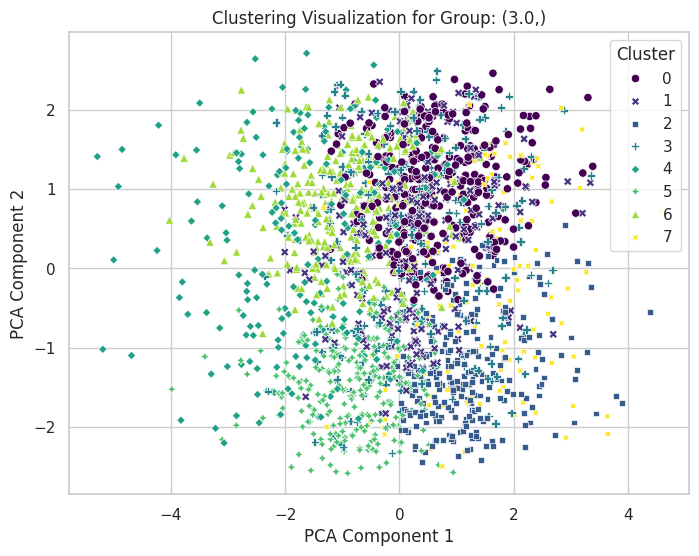

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

a = results_df['top_features']

for i, (group_name, group_data) in enumerate(cluster_df):
    row = a.iloc[i]
    features = [feature.strip() for feature in row.split(",")]
    filtered_group_df = group_data[features]

    # Normalize the data using StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(filtered_group_df)

    # Determine the optimal number of clusters using the Elbow Method
    inertia = []
    k_range = range(2, 10)  # Try cluster sizes from 2 to 10
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Method results
    plt.figure(figsize=(8, 6))
    plt.plot(k_range, inertia, marker="o")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title(f"Elbow Method for Group: {group_name}")
    plt.show()

    # Apply K-Means clustering with the chosen number of clusters
    optimal_k = 8  # Replace with the desired number of clusters after observing the Elbow Plot
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)

    # Add cluster labels to the group's DataFrame
    filtered_group_result = filtered_group_df.copy()
    filtered_group_result['Cluster'] = labels

    # Calculate clustering metrics
    if len(set(labels)) > 1:  # At least two clusters
        silhouette = silhouette_score(scaled_data, labels)
        davies_bouldin = davies_bouldin_score(scaled_data, labels)
        calinski_harabasz = calinski_harabasz_score(scaled_data, labels)

        print(f"Metrics for Group: {group_name}")
        print(f"  Silhouette Score: {silhouette:.3f}")
        print(f"  Davies-Bouldin Index: {davies_bouldin:.3f}")
        print(f"  Calinski-Harabasz Index: {calinski_harabasz:.3f}")
    else:
        print(f"Metrics for Group: {group_name}")
        print("  Clustering metrics not applicable (less than 2 clusters)")

    # Visualization
    # Reduce dimensionality for visualization using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        hue=labels,
        palette="viridis",
        style=labels,
        legend="full"
    )
    plt.title(f"Clustering Visualization for Group: {group_name}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.show()
